<a href="https://colab.research.google.com/github/FranceCawich/ColabPestDetecionCNN/blob/main/Detecion_de_pestes_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install patool
!pip install install keras_preprocessing
!pip3 install matplotlib
!pip3 install pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 997.8 kB/s eta 0:00:00


INFO patool: Extracting /content/data.zip ...
INFO:patool:Extracting /content/data.zip ...
INFO patool: running /usr/bin/7z x -o./Unpack_whbg3era -- /content/data.zip
INFO:patool:running /usr/bin/7z x -o./Unpack_whbg3era -- /content/data.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/data.zip extracted to `data8' (local file exists).
INFO:patool:... /content/data.zip extracted to `data8' (local file exists).


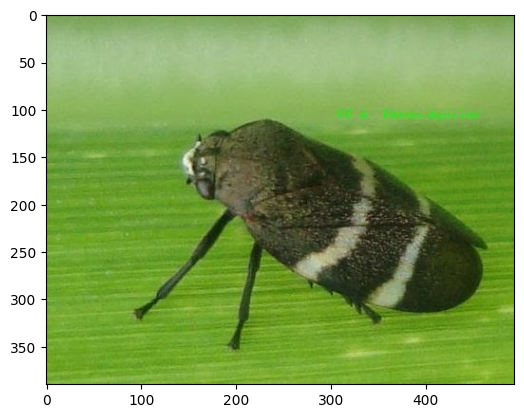

(390, 494, 3)
[[[121 163  89]
  [121 163  89]
  [121 163  89]
  ...
  [117 159  75]
  [117 159  75]
  [117 159  75]]

 [[122 164  90]
  [122 164  90]
  [122 164  90]
  ...
  [119 161  77]
  [119 161  77]
  [119 161  77]]

 [[125 165  92]
  [125 165  92]
  [125 165  92]
  ...
  [121 163  81]
  [121 163  81]
  [121 163  81]]

 ...

 [[129 180  62]
  [129 180  62]
  [129 180  62]
  ...
  [124 172  36]
  [123 171  33]
  [122 170  32]]

 [[128 179  61]
  [127 178  60]
  [126 177  59]
  ...
  [129 175  40]
  [129 176  38]
  [129 176  38]]

 [[124 175  57]
  [123 174  56]
  [122 173  55]
  ...
  [135 181  46]
  [136 183  45]
  [136 183  45]]]
Found 31 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
{'NoExsiste': 0, 'moscas': 1}
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 198, 198, 16)      448       
                          

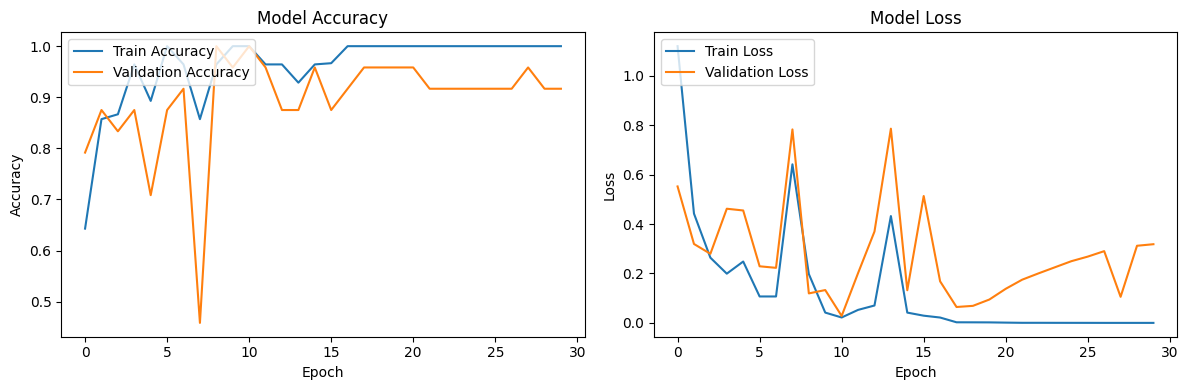

8/8 [==============================] - 0s 15ms/step


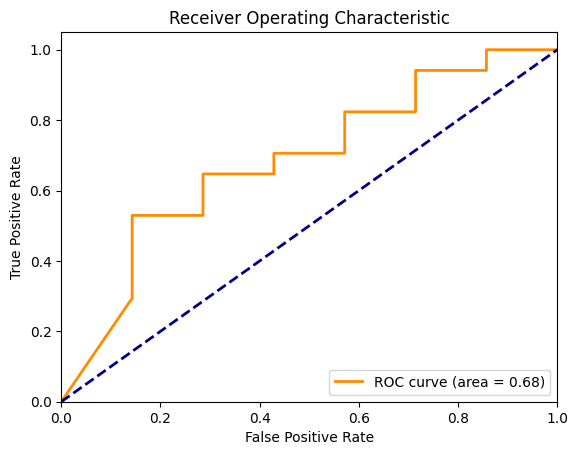

In [17]:
# Required imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import patoolib
from sklearn.metrics import roc_curve, auc
import random

seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

# Extract the dataset
patoolib.extract_archive('/content/data.zip')

# Display an example image from the dataset
img = tf.keras.preprocessing.image.load_img("/content/data/training/moscas/24.jpg")
plt.imshow(img)
plt.show()
print(np.array(img).shape)

# Convert an example image to a numpy array
im_1 = Image.open(r"/content/data/training/moscas/24.jpg")
ar = np.array(im_1)
print(ar)

# Preprocess the images for training and validation
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Load training and validation datasets using the generators
train_dataset = train_datagen.flow_from_directory(
    "/content/data/training/",
    target_size=(200, 200),
    batch_size=3,
    class_mode="binary"
)

validation_dataset = validation_datagen.flow_from_directory(
    "/content/data/validation/",
    target_size=(200, 200),
    batch_size=3,
    class_mode="binary"
)

print(train_dataset.class_indices)

# Define the CNN model architecture
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model and capture the history
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // train_dataset.batch_size,
    epochs=30,
    validation_data=validation_dataset,
    validation_steps=validation_dataset.samples // validation_dataset.batch_size
)

# Check keys in history.history
# Check keys in history.history
print(history.history.keys())

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()



# Generate predictions and true labels
y_pred_prob = model.predict(validation_dataset, steps=validation_dataset.samples // validation_dataset.batch_size)
y_true = validation_dataset.classes[:len(y_pred_prob)]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# New Section



9/9 [==============================] - 0s 29ms/step
Average Precision: 0.78


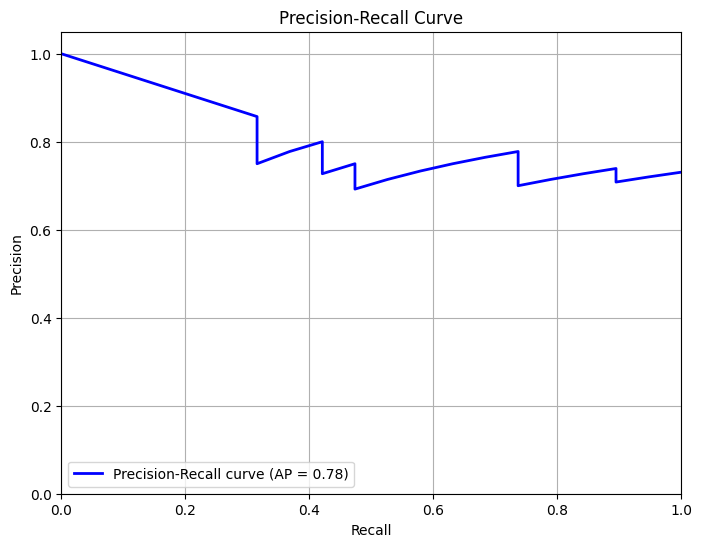

In [7]:
# Generate predictions on validation dataset
y_pred_prob = model.predict(validation_dataset, steps=len(validation_dataset))
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions
y_true = validation_dataset.classes  # True labels of the validation dataset


from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)

# Compute average precision score
average_precision = average_precision_score(y_true, y_pred_prob)
print(f'Average Precision: {average_precision:.2f}')


plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


INFO patool: Extracting /content/data.zip ...
INFO:patool:Extracting /content/data.zip ...
INFO patool: running /usr/bin/7z x -o./Unpack_pr29tr5h -- /content/data.zip
INFO:patool:running /usr/bin/7z x -o./Unpack_pr29tr5h -- /content/data.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/data.zip extracted to `data5' (local file exists).
INFO:patool:... /content/data.zip extracted to `data5' (local file exists).


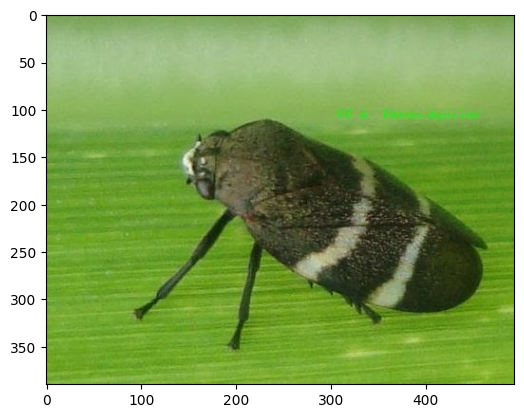

(390, 494, 3)
[[[121 163  89]
  [121 163  89]
  [121 163  89]
  ...
  [117 159  75]
  [117 159  75]
  [117 159  75]]

 [[122 164  90]
  [122 164  90]
  [122 164  90]
  ...
  [119 161  77]
  [119 161  77]
  [119 161  77]]

 [[125 165  92]
  [125 165  92]
  [125 165  92]
  ...
  [121 163  81]
  [121 163  81]
  [121 163  81]]

 ...

 [[129 180  62]
  [129 180  62]
  [129 180  62]
  ...
  [124 172  36]
  [123 171  33]
  [122 170  32]]

 [[128 179  61]
  [127 178  60]
  [126 177  59]
  ...
  [129 175  40]
  [129 176  38]
  [129 176  38]]

 [[124 175  57]
  [123 174  56]
  [122 173  55]
  ...
  [135 181  46]
  [136 183  45]
  [136 183  45]]]
Found 31 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
{'NoExsiste': 0, 'moscas': 1}
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 198, 198, 16)      448       
                          

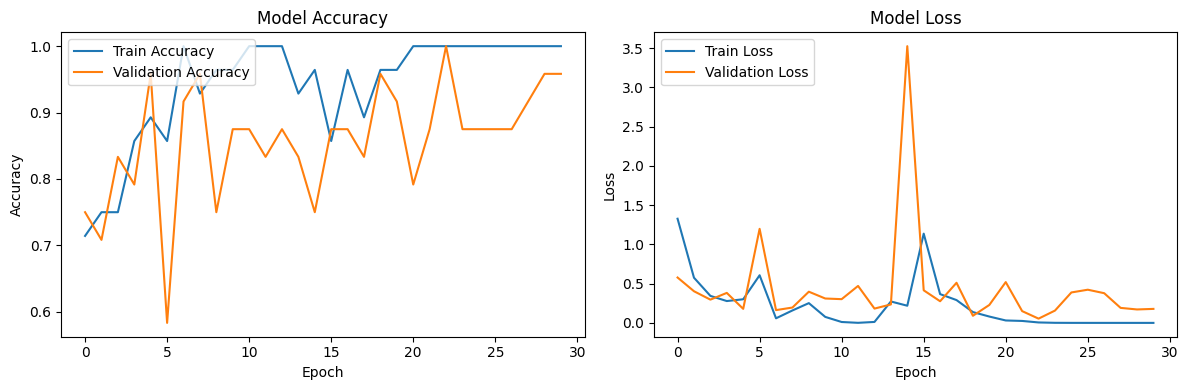

8/8 [==============================] - 0s 11ms/step


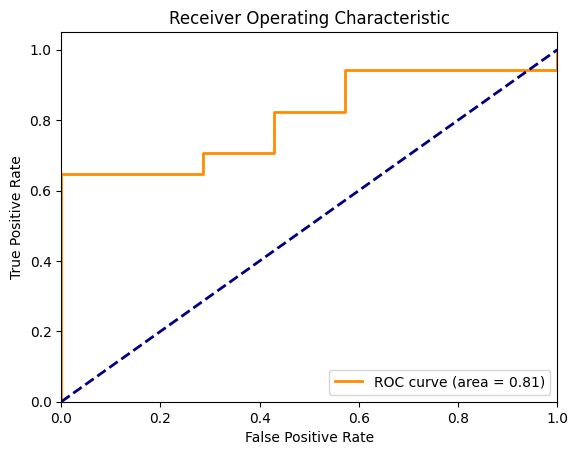

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import patoolib
from sklearn.metrics import roc_curve, auc

# Function to extract dataset
def extract_dataset(zip_file):
    patoolib.extract_archive(zip_file)

# Function to load and display an example image
def display_example_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path)
    plt.imshow(img)
    plt.show()
    print(np.array(img).shape)

# Function to convert an example image to a numpy array
def convert_to_numpy(image_path):
    im = Image.open(image_path)
    ar = np.array(im)
    print(ar)
    return ar

# Function to create and return ImageDataGenerator object
def create_datagen():
    return ImageDataGenerator(rescale=1/255)

# Function to load dataset using ImageDataGenerator
def load_dataset(datagen, directory, target_size, batch_size, class_mode):
    return datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode
    )

# Function to define CNN model architecture
def define_model(input_shape):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Function to plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Function to plot ROC curve
def plot_roc(y_true, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# Main function to execute the pipeline
def main():
    # Extract dataset
    extract_dataset('/content/data.zip')

    # Display an example image
    display_example_image("/content/data/training/moscas/24.jpg")

    # Convert example image to numpy array
    convert_to_numpy("/content/data/training/moscas/24.jpg")

    # Preprocess images for training and validation
    train_datagen = create_datagen()
    validation_datagen = create_datagen()

    # Load training and validation datasets
    train_dataset = load_dataset(train_datagen, "/content/data/training/", (200, 200), 3, "binary")
    validation_dataset = load_dataset(validation_datagen, "/content/data/validation/", (200, 200), 3, "binary")

    print(train_dataset.class_indices)

    # Define model
    model = define_model(input_shape=(200, 200, 3))

    # Print model summary
    model.summary()

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train model and capture history
    history = model.fit(
        train_dataset,
        steps_per_epoch=train_dataset.samples // train_dataset.batch_size,
        epochs=30,
        validation_data=validation_dataset,
        validation_steps=validation_dataset.samples // validation_dataset.batch_size
    )

    # Plot training and validation metrics
    plot_metrics(history)

    # Generate predictions and true labels
    y_pred_prob = model.predict(validation_dataset, steps=validation_dataset.samples // validation_dataset.batch_size)
    y_true = validation_dataset.classes[:len(y_pred_prob)]

    # Plot ROC curve
    plot_roc(y_true, y_pred_prob)

# Entry point of the script
if __name__ == "__main__":
    main()
